Color Plan ROI Diplay
============

This notebook may be used to show the projection of an ROI

In [5]:
import numpy as np
import yaml
import matplotlib.pyplot as plt
import cv2
import cv2.aruco as aruco

from enum import Enum

%matplotlib inline 

class PlayingSide(Enum):
    GREEN = -1
    ORANGE = 1

## Read configuration file

In [6]:
with open('../conf.yaml', 'r') as f:
    conf = yaml.load(f)
    
cameraMatrix = np.array(conf['camera']['cameraMatrix'])
cameraMatrix = cameraMatrix.reshape(3, 3)

distCoeffs = np.array(conf['camera']['distCoeffs'])

aruco_id = conf['ArUco']['id']
aruco_dict_id = conf['ArUco']['dict']
aruco_height = conf['ArUco']['height']

win_width = conf['process']['winWidth']
win_height = conf['process']['winHeight']

## Utils

In [7]:
def detect_aruco(im, aruco_id, aruco_dict_id, aruco_height, cameraMatrix, distCoeffs):
    def estimatePoseSingleMarkers(corners, aruco_height, cameraMatrix, distCoeffs):
        return cv2.aruco.estimatePoseSingleMarkers(corners,
                                                   aruco_height,
                                                   cameraMatrix,
                                                   distCoeffs)
    
    aruco_dict = aruco.Dictionary_get(aruco_dict_id)
    param = aruco.DetectorParameters_create()

    corners, ids, _ = aruco.detectMarkers(im, aruco_dict, parameters=param)
    sel_id = np.argwhere(ids == aruco_id)
    if sel_id.shape[0]:
        idx = sel_id[0][0]

        corners = [corners[idx]]

        rvecs, tvecs, _ = estimatePoseSingleMarkers(corners,
                                                   aruco_height,
                                                   cameraMatrix,
                                                   distCoeffs)
        print(tvecs)

        # The AruCo module in OpenCV have singularity that lead to
        # a wrong orientation estimation. We detect and correct these
        # using the knowledge we have about the possible position.
        rot_mat = cv2.Rodrigues(rvecs)[0]
        if np.sign(rot_mat[0, 1]) < 0 and np.sign(rot_mat[0, 2]) > 0:
            corners[idx][0][0] += 1
            rvecs, tvecs, _ = estimatePoseSingleMarkers(corners,
                                                   aruco_height,
                                                   cameraMatrix,
                                                   distCoeffs)
        elif np.sign(rot_mat[0, 1]) > 0 and np.sign(rot_mat[0, 2]) < 0:
            corners[idx][0][1] += np.array([-1, +1])
            rvecs, tvecs, _ = estimatePoseSingleMarkers(corners,
                                                   aruco_height,
                                                   cameraMatrix,
                                                   distCoeffs)
    else:
        corners, rvecs, tvecs = None, None, None

    return corners, rvecs, tvecs
    
def get_colormap_pts(conf, playing_side):
    if playing_side == PlayingSide.GREEN:
        areaY = conf['colorMap']['greenSide']['areaY']
        areaX = conf['colorMap']['greenSide']['areaX']
    else:
        areaY = conf['colorMap']['orangeSide']['areaY']
        areaX = conf['colorMap']['orangeSide']['areaX']

    areaHeight = conf['colorMap']['areaHeight']
    areaWidth = conf['colorMap']['areaWidth']

    return np.array([[areaX + areaWidth / 2, areaY + areaHeight / 2, 0],
                     [areaX - areaWidth / 2, areaY + areaHeight / 2, 0],
                     [areaX - areaWidth / 2, areaY - areaHeight / 2, 0],
                     [areaX + areaWidth / 2, areaY - areaHeight / 2, 0]],
                    dtype=np.float)

def draw_points(im, pts):
    im = im.copy()
    for p in pts:
        cv2.circle(im, (p[0], p[1]), 8, (0, 0, 255), -1)
    return im

def crop_on_color_map(im, pts, width, height):
    pts_proj = np.float32([[width, 0], [0, 0], [0, height], [width, height]])

    M = cv2.getPerspectiveTransform(pts.astype(np.float32), pts_proj)

    dst = cv2.warpPerspective(im, M, (width, height))
    return dst

## Process image and display output

[[[  45.1652549   -49.57353104  254.3115203 ]]]
PlayingSide.GREEN
[[1072  767]
 [ 960  768]
 [ 960  828]
 [1073  832]]


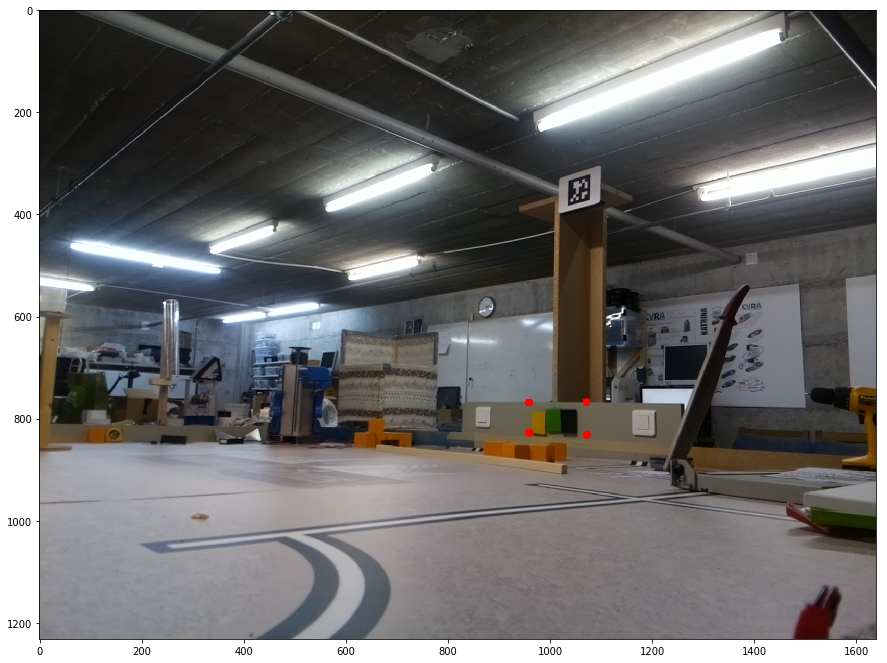

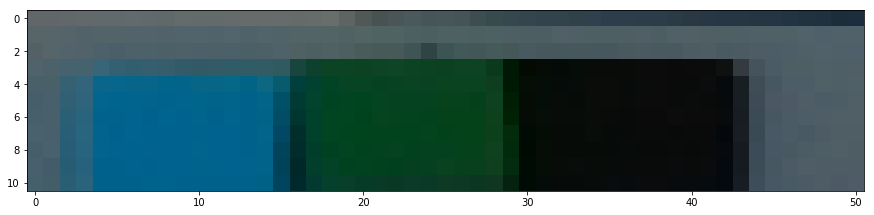

In [10]:
im = cv2.imread('2.png')
#im = cv2.resize(im, None, fx=0.25, fy=0.25, interpolation=cv2.INTER_AREA)

corners, rvecs, tvecs = detect_aruco(im, aruco_id, aruco_dict_id, aruco_height, cameraMatrix, distCoeffs)

if corners is not None:

    rot_mat = cv2.Rodrigues(rvecs)[0]
    if np.sign(rot_mat[0, 2]) > 0:
        playing_side = PlayingSide.ORANGE
    else:
        playing_side = PlayingSide.GREEN
    print(playing_side)
    
    pts, _ = cv2.projectPoints(get_colormap_pts(conf, playing_side), 
                               rvecs, tvecs,
                               cameraMatrix, distCoeffs)
    pts = np.rint(pts.squeeze()).astype(np.int)
    print(pts)
    crop = crop_on_color_map(im, pts, win_width, win_height)
        
    im_out = cv2.cvtColor(draw_points(im, pts), cv2.COLOR_RGB2BGR)
    
    plt.figure(figsize=(15, 15))
    plt.imshow(im_out)
    plt.show()
    
    plt.figure(figsize=(15, 15))
    plt.imshow(crop)
    plt.show()